In [ ]:
getwd()

In [ ]:
# create symlink to input data
system("ln -sfn ~/public/networks/WGCNA_excercise data/WGCNA")
# create output directory
system("mkdir -p out/WGCNA")

In [ ]:
suppressMessages(library(WGCNA))

In [ ]:
# We will analyze microarray expression data from the livers of female F2 intercross mice

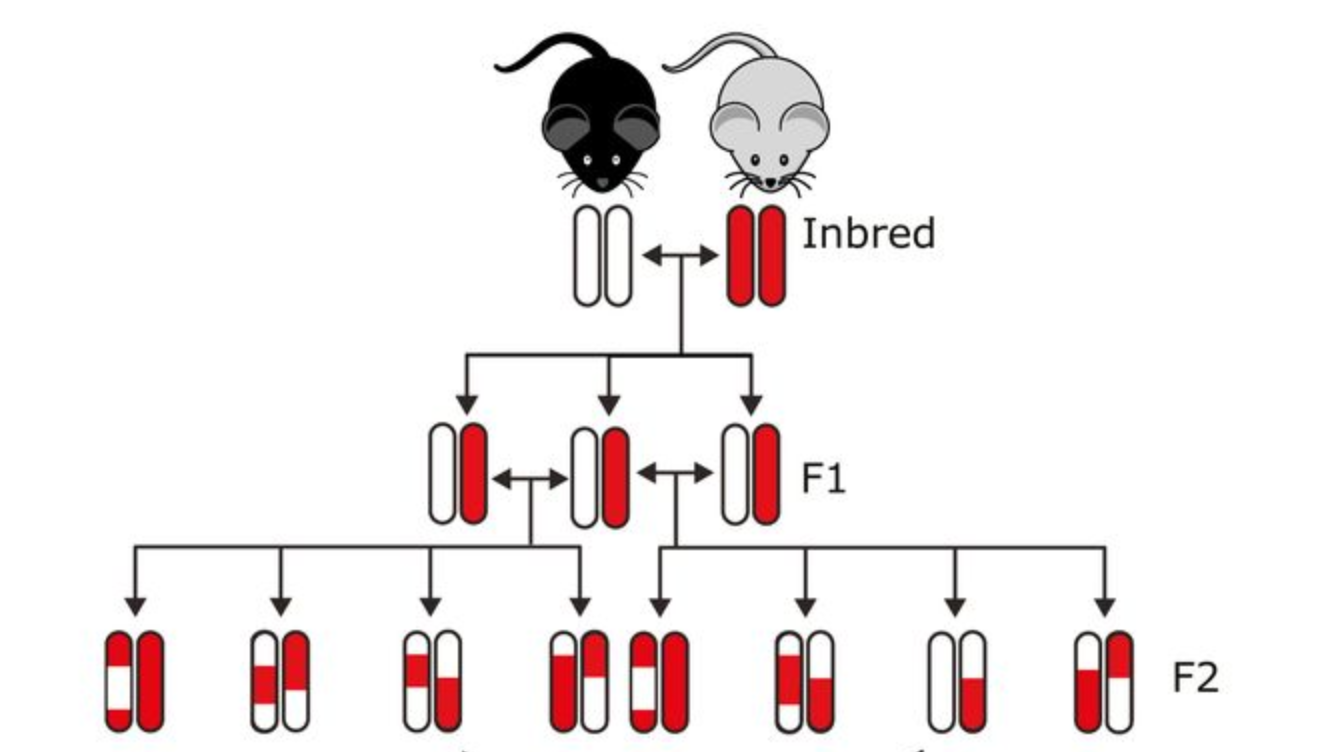

In [ ]:
# Load data - file contains expression levels of the top 3600 most variably expressed and most conntected genes
femData = read.csv("data/WGCNA/FemaleLiver-Data/LiverFemale3600.csv")
# Summary of dataset
dim(femData)
#names(femData)

In [ ]:
# Here's what the data look like
# Each row is a gene
# Columns 1-8 are metadata, 9+ are the gene expression values in the 135 mice

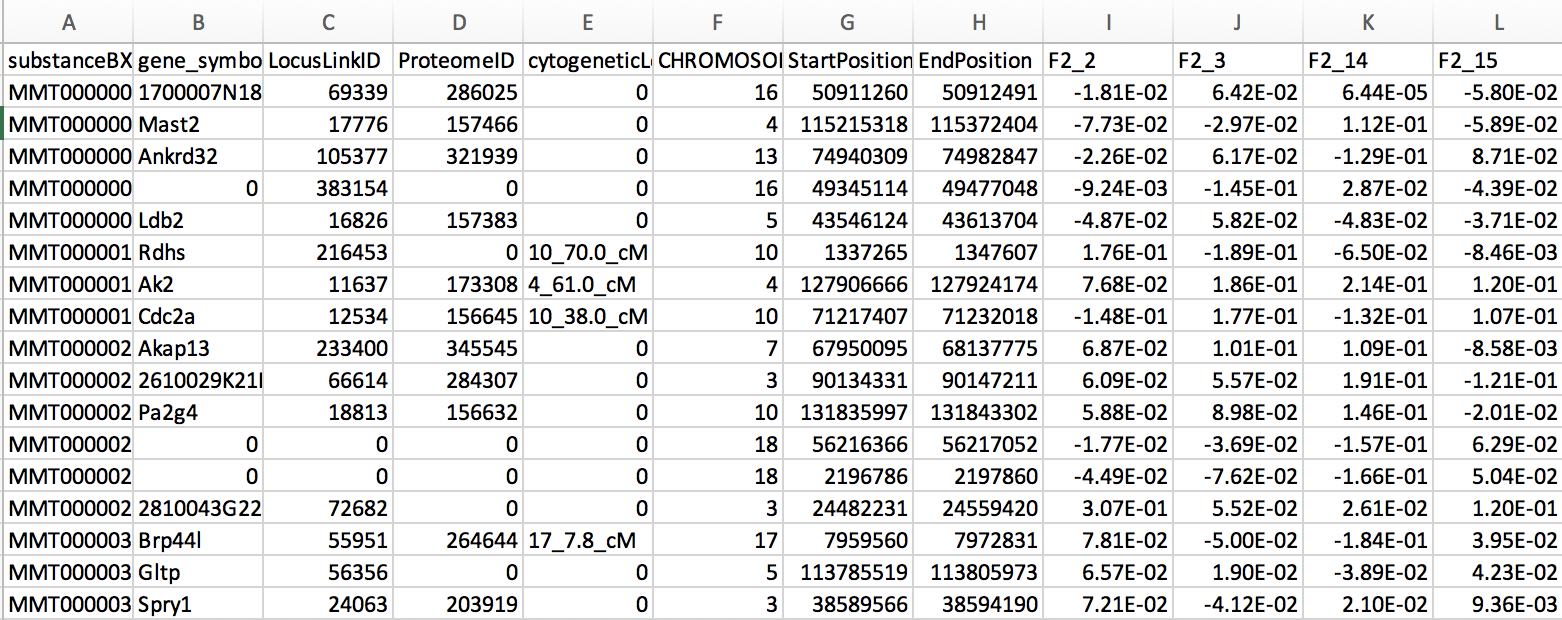

In [ ]:
# Put everything after the metadata into a data frame and update the row and column names
# Note that the data are transposed such that rows are now mice and columns are genes
datExpr0 = as.data.frame(t(femData[, -c(1:8)]))
names(datExpr0) = femData$substanceBXH
rownames(datExpr0) = names(femData)[-c(1:8)]
head(datExpr0)

In [ ]:
# WGNCA package built in function to evaluate missing values
gsg = goodSamplesGenes(datExpr0, verbose = 3)
gsg$allOK

In [ ]:
# Remove any low coverage genes or samples
if (!gsg$allOK)
{
  # Print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
     printFlush(paste("Removing genes:", paste(names(datExpr0)[!gsg$goodGenes], collapse = ", ")))
  if (sum(!gsg$goodSamples)>0) 
     printFlush(paste("Removing samples:", paste(rownames(datExpr0)[!gsg$goodSamples], collapse = ", ")))
  # Remove the offending genes and samples from the data:
  datExpr0 = datExpr0[gsg$goodSamples, gsg$goodGenes]
}

In [ ]:
dim(datExpr0)

In [ ]:
# Evaluate sample clustering on the basis of the 3600 genes
sampleTree = hclust(dist(datExpr0), method = "average")
# Plot the sample tree: Open a graphic output window of size 12 by 9 inches
# The user should change the dimensions if the window is too large or too small.
#sizeGrWindow(12,9)
#pdf(file = "Plots/sampleClustering.pdf", width = 12, height = 9);
par(cex = 0.6)
par(mar = c(0,4,2,0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5, cex.axis = 1.5, cex.main = 2)
# Plot a line to show the cut
abline(h = 15, col = "red");

In [ ]:
# We want to remove the one outlier sample from the dataset
# Determine cluster under the line
clust = cutreeStatic(sampleTree, cutHeight = 15, minSize = 10)
table(clust)
# clust 1 contains the samples we want to keep.
keepSamples = (clust==1)
datExpr = datExpr0[keepSamples, ]
nGenes = ncol(datExpr)
nSamples = nrow(datExpr)

In [ ]:
# Load and clean the phenotype data
traitData = read.csv("data/WGCNA/FemaleLiver-Data/ClinicalTraits.csv");
dim(traitData)
names(traitData)

# remove columns that hold information we do not need.
allTraits = traitData[, -c(31, 16)];
allTraits = allTraits[, c(2, 11:36) ];
dim(allTraits)
names(allTraits)

# Form a data frame analogous to expression data that will hold the clinical traits.
femaleSamples = rownames(datExpr);
traitRows = match(femaleSamples, allTraits$Mice);
datTraits = allTraits[traitRows, -1];
rownames(datTraits) = allTraits[traitRows, 1];

collectGarbage();
head(datTraits)
str(datTraits)

In [ ]:
# Visually summarize trait data w.r.t. to sample similarity
# Re-cluster samples (since we removed one)
sampleTree2 = hclust(dist(datExpr), method = "average")
# Convert traits to a color representation: white means low, red means high, grey means missing entry
# If you do this with your own data you may need to check what the trait values are stored as using e.g. str()
traitColors = numbers2colors(datTraits, signed = FALSE);
# Plot the sample dendrogram and the colors underneath.
plotDendroAndColors(sampleTree2, traitColors, groupLabels = names(datTraits), main = "Sample dendrogram and trait heatmap")

In [ ]:
system("mkdir -p out/WGCNA/FemaleLiver-Data")
save(datExpr, datTraits, file = "out/WGCNA/FemaleLiver-Data/FemaleLiver-01-dataInput.RData")

In [ ]:
options(stringsAsFactors = FALSE);
# Allow multi-threading within WGCNA. This helps speed up certain calculations.
# At present this call is necessary for the code to work.
# Any error here may be ignored but you may want to update WGCNA if you see one.
# Caution: skip this line if you run RStudio or other third-party R environments. 
# See note above.
enableWGCNAThreads()


In [ ]:
# WGCNA uses soft thresholding to convert gene co-expression (based on Pearson correlation) to an adjacency matrix
# This involves choosing a threshold parameter that results in a scale free network topology

# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 5)


In [ ]:
# Plot the results:
#sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [18]:
# In the above plot, a power parameter of 6 gives the best tradeoff  
# between a scale free topology and a high mean conntectivity
# WGNCA next identifies network modules based on similarity obtained from the Topological Overlap Matrix (TOM)
# Similarity is converted to a distance by subtracting it from 1, and the distance allows use of a dendrogram to 
# define modules
net = blockwiseModules(datExpr, power = 6,
                       TOMType = "unsigned", minModuleSize = 30,
                       reassignThreshold = 0, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs = TRUE,
                       saveTOMFileBase = "out/WGNCA/femaleMouseTOM", 
                       verbose = 3)

In [ ]:
# We can visualize the results by clustering genes based on their TOM distance 
# and coloring by gene modules inferred by WGNCA
# open a graphics window
#sizeGrWindow(12, 9)
# Convert labels to colors for plotting
mergedColors = labels2colors(net$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [ ]:
# Label modules according to their color name
# MEs = module eigengenes (first principal component within a module)
# MEs can be used to evaluate how related modules are
moduleLabels = net$colors
moduleColors = labels2colors(net$colors)
MEs = net$MEs
geneTree = net$dendrograms[[1]];
save(MEs, moduleLabels, moduleColors, geneTree, 
     file = "out/WGCNA/FemaleLiver-Data/FemaleLiver-02-networkConstruction-auto.RData")

In [ ]:
# Define numbers of genes and samples
nGenes = ncol(datExpr);
nSamples = nrow(datExpr);
# Recalculate MEs with color labels (gives gene x module color PC1 loading matrix)
MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
# Correlate within-module PC1 with trait values
moduleTraitCor = cor(MEs, datTraits, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);


In [ ]:
# Visualize the relationship between modules and traits
# Useful for selecting modules you'd like to investigate further
#sizeGrWindow(10,6)
# Will display correlations and their p-values
textMatrix =  paste(signif(moduleTraitCor, 2), "\n(",signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3));
# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = names(datTraits),
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = greenWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))


In [ ]:
# Look at modules/genes that are significantly associated with weight

# Define variable weight containing the weight column of datTrait
weight = as.data.frame(datTraits$weight_g)
names(weight) = "weight"
# names (colors) of the modules
modNames = substring(names(MEs), 3)

# Gene module membership is evaluated based on cross correlation between gene expression values and module loadings
geneModuleMembership = as.data.frame(cor(datExpr, MEs, use = "p"))
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))

names(geneModuleMembership) = paste("MM", modNames, sep="")
names(MMPvalue) = paste("p.MM", modNames, sep="")

# Get significance of gene expression correlation with trait
geneTraitSignificance = as.data.frame(cor(datExpr, weight, use = "p"))
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))

names(geneTraitSignificance) = paste("GS.", names(weight), sep="")
names(GSPvalue) = paste("p.GS.", names(weight), sep="")

In [ ]:
# You can visualize the relationship between a gene's membership in a module and its association with a trait
# Here genes that drive the identitity of the brown module are also more significantly associated with weight
module = "brown"
column = match(module, modNames);
moduleGenes = moduleColors==module;

#summary(geneTraitSignificance[moduleGenes, 1])

#sizeGrWindow(7, 7);
par(mfrow = c(1,1));
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene association with body weight",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)



In [ ]:
# Gene membership in the brown module
head(names(datExpr)[moduleColors=="brown"])
length(names(datExpr)[moduleColors=="brown"])

In [ ]:
# Next we will update the gene names with mappings from probes to genes
annot = read.csv(file = "data/WGCNA/FemaleLiver-Data/GeneAnnotation.csv");
dim(annot)
#names(annot)
head(annot)
probes = names(datExpr)
probes2annot = match(probes, annot$substanceBXH)
# The following is the number or probes without annotation:
sum(is.na(probes2annot))
# Should return 0.

In [ ]:
# Create a new data frame to store gene information
geneInfo0 = data.frame(substanceBXH = probes,
                      geneSymbol = annot$gene_symbol[probes2annot],
                      LocusLinkID = annot$LocusLinkID[probes2annot],
                      moduleColor = moduleColors,
                      geneTraitSignificance,
                      GSPvalue)
# Order modules by their significance for weight
modOrder = order(-abs(cor(MEs, weight, use = "p")));
# Add module membership information in the chosen order
for (mod in 1:ncol(geneModuleMembership))
{
  oldNames = names(geneInfo0)
  geneInfo0 = data.frame(geneInfo0, geneModuleMembership[, modOrder[mod]], 
                         MMPvalue[, modOrder[mod]]);
  names(geneInfo0) = c(oldNames, paste("MM.", modNames[modOrder[mod]], sep=""),
                       paste("p.MM.", modNames[modOrder[mod]], sep=""))
}
# Order the genes in the geneInfo variable first by module color, then by geneTraitSignificance
geneOrder = order(geneInfo0$moduleColor, -abs(geneInfo0$GS.weight));
geneInfo = geneInfo0[geneOrder, ]

In [ ]:
head(geneInfo)
write.csv(geneInfo, file = "out/WGCNA/FemaleLiver-Data/geneInfo.csv")

In [ ]:
# Match probes in the data set to the probe IDs in the annotation file 
probes = names(datExpr)
probes2annot = match(probes, annot$substanceBXH)
# Get the corresponding Locuis Link IDs
allLLIDs = annot$LocusLinkID[probes2annot];
# Choose interesting modules
intModules = c("brown", "red", "salmon")
for (module in intModules)
{
  # Select module probes
  modGenes = (moduleColors==module)
  # Get their entrez ID codes
  modLLIDs = allLLIDs[modGenes];
  # Write them into a file
  fileName = paste("out/WGCNA/LocusLinkIDs-", module, ".txt", sep="");
  write.table(as.data.frame(modLLIDs), file = fileName,
              row.names = FALSE, col.names = FALSE)
}
# As background in the enrichment analysis, we will use all probes in the analysis.
fileName = paste("out/WGCNA/LocusLinkIDs-all.txt", sep="");
write.table(as.data.frame(allLLIDs), file = fileName,
            row.names = FALSE, col.names = FALSE)


In [ ]:
# Perform GO enrichment analysis on each module, keeping the top ten annotations
GOenr = GOenrichmentAnalysis(moduleColors, allLLIDs, organism = "mouse", nBestP = 10);

In [ ]:
tab = GOenr$bestPTerms[[4]]$enrichment
names(tab)
write.table(tab, file = "out/WGCNA/FemaleLiver-Data/GOEnrichmentTable.csv", sep = ",", quote = TRUE, row.names = FALSE)

In [ ]:
# Drop columns that are not needed and clean up for visualization
keepCols = c(1, 2, 5, 6, 7, 12, 13);
screenTab = tab[, keepCols];
# Round the numeric columns to 2 decimal places:
numCols = c(3, 4);
screenTab[, numCols] = signif(apply(screenTab[, numCols], 2, as.numeric), 2)
# Truncate the the term name to at most 40 characters
screenTab[, 7] = substring(screenTab[, 7], 1, 40)
# Shorten the column names:
colnames(screenTab) = c("module", "size", "p-val", "Bonf", "nInTerm", "ont", "term name");
rownames(screenTab) = NULL;
# Set the width of R's output. The reader should play with this number to obtain satisfactory output.
options(width=95)
# Finally, display the enrichment table:
screenTab


In [ ]:
# Visualize the network adjacency matrix together with a dendrogram of gene distances and module colors
# Calculate topological overlap distance anew
# We calculated in during module detection, but let's do it again here.
dissTOM = 1-TOMsimilarityFromExpr(datExpr, power = 6);
# Transform dissTOM with a power to make moderately strong connections more visible in the heatmap
plotTOM = dissTOM^7;
# Set diagonal to NA for a nicer plot
diag(plotTOM) = NA;
# Call the plot function
#sizeGrWindow(9,9)
TOMplot(plotTOM, geneTree, moduleColors, main = "Network heatmap plot, all genes")



In [ ]:
# Revisit with 400 randomly selected genes
# This runs faster than the larger network while returning similar substructure
# It also gives some idea of how robust the solution is
nSelect = 400
# For reproducibility, we set the random seed
set.seed(10);
select = sample(nGenes, size = nSelect);
selectTOM = dissTOM[select, select];
# There's no simple way of restricting a clustering tree to a subset of genes, so we must re-cluster.
selectTree = hclust(as.dist(selectTOM), method = "average")
selectColors = moduleColors[select];
# Open a graphical window
#sizeGrWindow(9,9)
# Taking the dissimilarity to a power, say 10, makes the plot more informative by effectively changing 
# the color palette; setting the diagonal to NA also improves the clarity of the plot
plotDiss = selectTOM^7;
diag(plotDiss) = NA;
TOMplot(plotDiss, selectTree, selectColors, main = "Network heatmap plot, selected genes")



In [ ]:
# Visualize similarity of modules based on within module PC1 loadings
# Each mouse has a module eigengene value within each module
# Here, a trait (weight) is included which allows to see which modules correlate most with that trait
# Recalculate module eigengenes
MEs = moduleEigengenes(datExpr, moduleColors)$eigengenes
# Isolate weight from the clinical traits
weight = as.data.frame(datTraits$weight_g);
names(weight) = "weight"
# Add the weight to existing module eigengenes
MET = orderMEs(cbind(MEs, weight))
# Plot the relationships among the eigengenes and the trait
#sizeGrWindow(5,7.5);
par(cex = 0.9)
plotEigengeneNetworks(MET, "", marDendro = c(0,4,1,2), marHeatmap = c(3,4,1,2), cex.lab = 0.8, xLabelsAngle
= 90)

In [ ]:
# You can also plot the heatmap and dendrogram separately
# Plot the dendrogram
#sizeGrWindow(6,6);
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene dendrogram", marDendro = c(0,4,2,0),
                      plotHeatmaps = FALSE)
# Plot the heatmap matrix (note: this plot will overwrite the dendrogram plot)
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene adjacency heatmap", marHeatmap = c(3,4,2,2),
                      plotDendrograms = FALSE, xLabelsAngle = 90)


In [ ]:
# Now we will prepare the data for visualization with 3rd party tools
# Recalculate topological overlap 
TOM = TOMsimilarityFromExpr(datExpr, power = 6);


In [ ]:
# Here we generate a file for VisANT from a single module
# Read in the annotation file
annot = read.csv(file = "data/WGCNA/FemaleLiver-Data/GeneAnnotation.csv");
# Select module
module = "brown";
# Select module probes
probes = names(datExpr)
inModule = (moduleColors==module);
modProbes = probes[inModule];
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];
dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into an edge list file VisANT can read
vis = exportNetworkToVisANT(modTOM,
  file = paste("out/WGCNA/VisANTInput-", module, ".txt", sep=""),
  weighted = TRUE,
  threshold = 0,
  probeToGene = data.frame(annot$substanceBXH, annot$gene_symbol) )


In [ ]:
# Export only the top 30 most connected genes in the module for visualization with VisANT software
nTop = 30;
IMConn = softConnectivity(datExpr[, modProbes]);
top = (rank(-IMConn) <= nTop)
vis = exportNetworkToVisANT(modTOM[top, top],
  file = paste("out/WGCNA/VisANTInput-", module, "-top30.txt", sep=""),
  weighted = TRUE,
  threshold = 0,
  probeToGene = data.frame(annot$substanceBXH, annot$gene_symbol) )


In [ ]:
# Export data for visualization with Cytoscape
# Select modules
modules = c("brown", "red");
# Select module probes
probes = names(datExpr)
inModule = is.finite(match(moduleColors, modules));
modProbes = probes[inModule];
modGenes = annot$gene_symbol[match(modProbes, annot$substanceBXH)];
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];
dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into edge and node list files Cytoscape can read
cyt = exportNetworkToCytoscape(modTOM,
  edgeFile = paste("out/WGCNA/CytoscapeInput-edges-", paste(modules, collapse="-"), ".txt", sep=""),
  nodeFile = paste("out/WGCNA/CytoscapeInput-nodes-", paste(modules, collapse="-"), ".txt", sep=""),
  weighted = TRUE,
  threshold = 0.02,
  nodeNames = modProbes,
  altNodeNames = modGenes,
  nodeAttr = moduleColors[inModule]);

